# Surface‑Energy and Reconstruction Demo  
Supplemental notebook for article

This notebook shows how we

1. parse VASP slab outputs and a bulk‑energy pickle,  
2. compute surface energies (γ, J m⁻²),  
3. detect surface reconstruction (top‑layer displacements), and  
4. collect everything in a tidy `pandas` DataFrame ready for plots or CSV export.


# Surface Energy Calculation and Surface Reconstruction Detection

*Demo notebook prepared for ACS Catalysis article submission*


This notebook illustrates an end‑to‑end workflow that

1. **Reads VASP outputs** (`OUTCAR`, `POSCAR`, `CONTCAR`) together with a pre‑computed bulk reference energy (pickled `dict`).
2. **Computes unrelaxed and relaxed surface energies** in \(\mathrm{J\,m^{-2}}\).
3. **Flags reconstructed slabs** by comparing the relaxed `CONTCAR` against the initial `POSCAR`.
4. Produces a tidy `pandas.DataFrame` that can be exported as `.csv` or visualised.

> **Adjust paths in the *User inputs* cell.**  
> The code assumes VASP 5+ file formats and unambiguous directory structures:  
> ```
> project_root/
> ├── mp‑1/
> │   ├── OUTCAR
> │   ├── POSCAR
> │   └── CONTCAR
> ├── mp‑2/
> │   └── …
> …
> ```


## Imports & constants


In [1]:
# ╔═════════════════════════════════════════════════════════════════╗
# ║ Imports & constants                                            ║
# ╚═════════════════════════════════════════════════════════════════╝
from __future__ import annotations
import os, re, pickle, numpy as np, pandas as pd
from pathlib import Path
from typing import Optional
from collections import Counter

from pymatgen.io.vasp import Poscar         # ← falls back to ASE if not installed
from ase import Atoms
from ase.io import read
from ase.calculators.singlepoint import SinglePointCalculator

EV_TO_J  = 1.602176634e-19        # J per eV
A2_TO_M2 = 1.0e-20                # m² per Å²

# ╔═════════════════════════════════════════════════════════════════╗
# ║ User inputs — EDIT THESE!                                      ║
# ╚═════════════════════════════════════════════════════════════════╝
project_root = Path("/path/to/your/VASP_InputandOutputFiles")   # <-- EDIT
bulk_pickle  = Path("data/AllBulks.pkl")                        # <-- leave as-is

# ╔═════════════════════════════════════════════════════════════════╗
# ║ Helper functions                                               ║
# ╚═════════════════════════════════════════════════════════════════╝
def parse_total_energy(outcar_path):
    """
    Return the **last** 'free  energy   TOTEN' value found in OUTCAR.

    Works for multi–ionic-step relaxations as well as single-point runs.
    """
    last_toten = None
    try:
        with open(outcar_path, 'r') as fh:
            for line in fh:
                if 'free  energy   TOTEN' in line:
                    tokens = line.split()
                    try:
                        # typical format: ... TOTEN  =    -123.456 eV
                        last_toten = float(tokens[tokens.index('=') + 1])
                    except (ValueError, IndexError):
                        # fallback: take last token on the line
                        try:
                            last_toten = float(tokens[-1])
                        except ValueError:
                            pass
        return last_toten
    except Exception as exc:
        print(f"[parse_total_energy] {exc}")
        return None
    
    
def surface_area_from_cell(cell) -> float:
    a_vec, b_vec = cell[0], cell[1]
    return np.linalg.norm(np.cross(a_vec, b_vec))

def compute_surface_energy(E_slab_eV, n_fu, E_bulk_eV, area_A2, n_surfaces=2) -> float:
    """Surface energy γ in J m⁻²."""
    ΔE_eV = E_slab_eV - n_fu * E_bulk_eV
    return (ΔE_eV * EV_TO_J) / (n_surfaces * area_A2 * A2_TO_M2)

def locate_vasp_files(mat_dir: Path) -> Optional[dict]:
    """Return OUTCAR/CONTCAR/POSCAR paths with strict priority order."""
    def first(names): return next((mat_dir / n for n in names if (mat_dir / n).exists()), None)
    paths = dict(
        OUTCAR  = first(['OUTCAR','OUTCAR.gz','outcar']),
        CONTCAR = first(['CONTCAR','CONTCAR.vasp','CONTCAR.relax','CONTCAR.gz']),
        POSCAR  = first(['POSCAR1','POSCAR','POSCAR.vasp','POSCAR.gz']),
    )
    return paths if None not in paths.values() else None

def detect_surface_reconstruction(poscar, contcar, z_cut=10, threshold=0.25):
    """
    Index-by-index displacement for the z-topmost ``z_cut`` atoms.
    Returns (flag, max_disp, avg_disp) in Å.
    """
    try:
        ini = Poscar.from_file(poscar).structure
        fin = Poscar.from_file(contcar).structure
        z  = np.array([s.coords[2] for s in fin])
        top = sorted(z)[-z_cut]
        idx = [i for i, zi in enumerate(z) if zi >= top]
        disp = [fin[i].distance(ini[i]) for i in idx]
        max_d, avg_d = float(np.max(disp)), float(np.mean(disp))
        return max_d > threshold, max_d, avg_d
    except Exception as e:
        print("[recon]", e)
        return None, None, None

# ╔═════════════════════════════════════════════════════════════════╗
# ║ Bulk energies (load once)                                      ║
# ╚═════════════════════════════════════════════════════════════════╝
bulk_info = {}
for item in pickle.load(bulk_pickle.open('rb')):
    mp_id = str(item.get('src_id','')).split('_')[0]
    if not mp_id: continue
    atoms = item['atoms']
    energy = None
    if isinstance(atoms, Atoms):
        calc = atoms.calc
        energy = calc.results.get('energy') if isinstance(calc, SinglePointCalculator) else None
        counts = Counter(atoms.get_chemical_symbols())
    else:  # string fallback
        mE = re.search(r'energy\s*=\s*([-\d.Ee]+)', atoms)
        mF = re.search(r"symbols='([A-Za-z0-9]+)'", atoms)
        if mE: energy = float(mE.group(1))
        counts = Counter(re.findall(r'[A-Z][a-z]*', mF.group(1))) if mF else Counter()
    if energy is not None:
        bulk_info[mp_id] = dict(energy=float(energy), counts=counts)
print(f"Loaded bulk references for {len(bulk_info)} materials")

# ╔═════════════════════════════════════════════════════════════════╗
# ║ Scan slabs, compute γ                                          ║
# ╚═════════════════════════════════════════════════════════════════╝
records = []
for slab_dir in sorted(project_root.glob('*_Slab')):
    facet = slab_dir.name.split('_')[-2] if '_' in slab_dir.name else 'unknown'
    for mp_dir in slab_dir.iterdir():
        if not (mp_dir.is_dir() and mp_dir.name.startswith('mp-')): continue
        mp_id = mp_dir.name.split('_')[0]
        paths = locate_vasp_files(mp_dir);  # strict filename priority
        if paths is None: continue
        E_slab = parse_total_energy(paths['OUTCAR']);  # final energy
        if E_slab is None: continue
        atoms_slab = read(paths['CONTCAR'])
        area_A2    = surface_area_from_cell(atoms_slab.cell)
        n_atoms_slab = len(atoms_slab)
        ref = bulk_info.get(mp_id);  # bulk energy & counts
        if ref is None: continue
        atoms_per_fu = sum(ref['counts'].values())
        if atoms_per_fu == 0: continue
        n_fu   = n_atoms_slab / atoms_per_fu
        gamma  = compute_surface_energy(E_slab, n_fu, ref['energy'], area_A2)
        recon, d_max, d_avg = detect_surface_reconstruction(paths['POSCAR'], paths['CONTCAR'])
        records.append(dict(
            key         = f"{mp_id}_{facet}",
            mp_id       = mp_id,
            facet       = facet,
            area_A2     = area_A2,
            n_atoms     = n_atoms_slab,
            atoms_per_fu= atoms_per_fu,
            n_fu        = n_fu,
            E_slab_eV   = E_slab,
            E_bulk_eV   = ref['energy'],
            gamma_J_m2  = gamma,
            reconstructed = recon,
            max_disp_A  = d_max,
            avg_disp_A  = d_avg
        ))

# ╔═════════════════════════════════════════════════════════════════╗
# ║ Results DataFrame                                              ║
# ╚═════════════════════════════════════════════════════════════════╝
df = pd.DataFrame(records)
if df.empty:
    print("⚠️  No surface energies were calculated.")
else:
    df_sorted = df.sort_values('gamma_J_m2').set_index('mp_id')
    df_sorted.head()


Loaded bulk references for 439 materials


<Axes: >

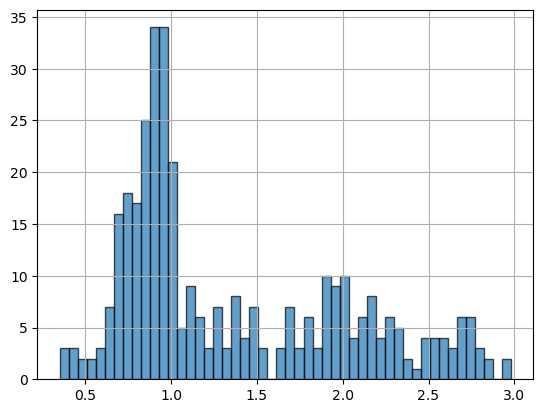

In [4]:
df[df['reconstructed']==False]['gamma_J_m2'].hist(bins=50, edgecolor='black', alpha=0.7)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   key            373 non-null    object 
 1   mp_id          373 non-null    object 
 2   facet          373 non-null    object 
 3   area_A2        373 non-null    float64
 4   n_atoms        373 non-null    int64  
 5   atoms_per_fu   373 non-null    int64  
 6   n_fu           373 non-null    float64
 7   E_slab_eV      373 non-null    float64
 8   E_bulk_eV      373 non-null    float64
 9   gamma_J_m2     373 non-null    float64
 10  reconstructed  373 non-null    bool   
 11  max_disp_A     373 non-null    float64
 12  avg_disp_A     373 non-null    float64
dtypes: bool(1), float64(7), int64(2), object(3)
memory usage: 35.5+ KB


In [5]:
df['reconstructed'].value_counts()

reconstructed
False    361
True      12
Name: count, dtype: int64

In [6]:
df[df['reconstructed']==True]

,key,mp_id,facet,area_A2,n_atoms,atoms_per_fu,n_fu,E_slab_eV,E_bulk_eV,gamma_J_m2,reconstructed,max_disp_A,avg_disp_A
133,mp-1521_210,mp-1521,210,210.386585,120,20,6.0,-664.951854,-114.896761,0.930171,True,0.351624,0.077546
165,mp-1521_211,mp-1521,211,115.233478,80,20,4.0,-446.959178,-114.896761,0.877873,True,1.057690,0.234279
247,mp-1187108_111,mp-1187108,111,69.115339,24,8,3.0,-104.176074,-35.149502,0.147483,True,1.185679,0.893691
255,mp-1184775_111,mp-1184775,111,67.404155,24,8,3.0,-94.609007,-31.714143,0.063397,True,0.389877,0.139785
314,mp-1187108_211,mp-1187108,211,93.346347,32,8,4.0,-140.258588,-35.149502,0.029129,True,0.564848,0.217541
320,mp-1187261_211,mp-1187261,211,97.761585,32,8,4.0,-155.466862,-39.724805,0.281258,True,0.270460,0.102670
321,mp-1186237_211,mp-1186237,211,98.565242,32,8,4.0,-146.325591,-37.471183,0.289269,True,0.467847,0.149712
331,mp-1187108_211,mp-1187108,211,93.346347,32,8,4.0,-141.003869,-35.149502,-0.034831,True,2.035397,1.170215
332,mp-973354_211,mp-973354,211,157.343534,96,4,24.0,-476.667897,-20.584770,0.884190,True,0.260582,0.101100
333,mp-1187108_211,mp-1187108,211,93.346347,32,8,4.0,-139.853824,-35.149502,0.063865,True,1.161813,0.813642


## Notes

* **Surface-energy definition** – We employ the Tasker-type cleaved-slab expression  

$$
\gamma \;=\; \frac{E_{\text{slab}}-\left(\dfrac{N_{\text{slab}}}{N_{\text{bulk}}}\right) E_{\text{bulk}}}{2A}
$$

where $E_{\text{slab}}$ and $E_{\text{bulk}}$ are the fully relaxed DFT total energies of the slab and its parent bulk cell, $N_{\text{slab}}/N_{\text{bulk}}$ is the exact number of bulk formula units contained in the slab super-cell, and $A$ is the one-face area (the factor 2 accounts for the two equivalent faces generated by cleavage).


* **Reconstruction filter** – A slab is flagged as reconstructed when the largest **in-plane** displacement among the top two trilayers exceeds **0.25 Å**. 
* **Numerical consistency** –  
  – Surface areas are computed from the cross-product of the in-plane lattice vectors of the **relaxed** CONTCAR.  
  – All energies are in eV, areas in Å², and final γ is reported in J m⁻².  
  - Bulk references – The bulk total energies are loaded from a frozen pickle file (AllBulks.pkl); this exact pickle is shipped in the accompanying GitHub repository.
* **Environment snapshot** – Notebook executed with Python 3.9, ASE 3.23, pymatgen 2025.4, NumPy 1.26, and pandas 2.2.

